# The Battle of Neighborhoods (Week 1-2)

## Backgound

A new investor that just moved to Toronto, Ontario wants to invest in a new business but is not sure which is most profitable to him. Ontario is the second-largest province by total area in Canada. It is home to the nation's capital city, Ottawa, and the nation's most populous city, Toronto.

## Business Problem

To help solve the problem, we will need to use machine learning algorithms to determine the most explored venues in a particular neighborhood. The business questions we are posed with are: How do we determine the venues in Ontario and what business do we recommend a business to the investor?

To solve this problem, we will make use of Foursquare Api to get the most explored venues in eachh neighborhood and depending on the neighborhood of choice of the investor, we will recommend a profitable business.

## Data Section

For this project, we make use of the following data
   1. Neighborhood in Toronto
        -Source: https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M
        -This data set contains required information to get the neighborhoods existing in Toronto
   2. Longitude and Latitude of Each Neighborhood
        -Source: https://cocl.us/Geospatial_data/Geospatial_Coordinates.csv
        -This data set contains the longitude and latitude of each neighborhood in Ontario
   3. Venues In Each Neighborhood
        -Source: https://developer.foursquare.com/
        -Leveraging Four square Api, we can generate most explored venues in each neighborhood.
        
## Methodology
The Methodology section includes:

    1.Collection of Inspection Data
    2.Exploration and Understanding Data
    3.Data preparation and preprocessing
    4.Modeling

In [1]:
#Importing the Library 
from bs4 import BeautifulSoup
import requests
import pandas as pd
import numpy as np
import json # library to handle JSON files
import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import folium # map rendering library

In [2]:
#Generating Beautiful soup Object to scrape the wikipage
url ='https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M'
response = requests.get(url)
#Process and convert html data
data = response.text
soup = BeautifulSoup(data,'html.parser')

In [3]:
#Scraping the webpage from the wiki
table_contents=[]
table=soup.find('table')
for row in table.findAll('td'):
    cell = {}
    if row.span.text=='Not assigned':
        pass
    else:
        cell['PostalCode'] = row.p.text[:3]
        cell['Borough'] = (row.span.text).split('(')[0]
        cell['Neighborhood'] = (((((row.span.text).split('(')[1]).strip(')')).replace(' /',',')).replace(')',' ')).strip(' ')
        table_contents.append(cell)

# print(table_contents)
df=pd.DataFrame(table_contents)
df['Borough']=df['Borough'].replace({'Downtown TorontoStn A PO Boxes25 The Esplanade':'Downtown Toronto Stn A',
                                             'East TorontoBusiness reply mail Processing Centre969 Eastern':'East Toronto Business',
                                             'EtobicokeNorthwest':'Etobicoke Northwest','East YorkEast Toronto':'East York/East Toronto',
                                             'MississaugaCanada Post Gateway Processing Centre':'Mississauga'})
df.head()

,PostalCode,Borough,Neighborhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,"Regent Park, Harbourfront"
3,M6A,North York,"Lawrence Manor, Lawrence Heights"
4,M7A,Queen's Park,Ontario Provincial Government


In [4]:
df.shape

(103, 3)

In [5]:
#Generating the longitude and latitude of each borough
lat_lng=pd.read_csv('https://cocl.us/Geospatial_data/Geospatial_Coordinates.csv')
lat_lng.head()

,Postal Code,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


In [6]:
#Finetune the postal code column name and then merge dataframes
lat_lng = lat_lng.rename(columns = {'Postal Code':'PostalCode'}) 
df = pd.merge(df, lat_lng, how= 'inner', on = 'PostalCode')
df.head()

,PostalCode,Borough,Neighborhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.753259,-79.329656
1,M4A,North York,Victoria Village,43.725882,-79.315572
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763
4,M7A,Queen's Park,Ontario Provincial Government,43.662301,-79.389494


In [7]:
#Final Clean up of Data frame
df_explore=df.drop(columns=['PostalCode'])
df_explore.head()

,Borough,Neighborhood,Latitude,Longitude
0,North York,Parkwoods,43.753259,-79.329656
1,North York,Victoria Village,43.725882,-79.315572
2,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636
3,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763
4,Queen's Park,Ontario Provincial Government,43.662301,-79.389494


### Create a map of ontario with the Borough as markers

In [8]:
address = 'Toronto, Ontario'
geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Toronto are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Toronto are 43.6534817, -79.3839347.


In [9]:
map_toronto = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, borough, neighborhood in zip(df_explore['Latitude'], df_explore['Longitude'], df_explore['Borough'], df_explore['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)  
    
map_toronto

## Determining most explored Neighborhoods

In [10]:
CLIENT_ID = 'your client id' # your Foursquare ID
CLIENT_SECRET = 'ypur client secret' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
LIMIT = 100 # A default Foursquare API limit value

In [11]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])
        

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [12]:
Toronto = getNearbyVenues(names=df_explore['Neighborhood'],
                                   latitudes=df_explore['Latitude'],
                                   longitudes=df_explore['Longitude']
                                  )

Parkwoods
Victoria Village
Regent Park, Harbourfront
Lawrence Manor, Lawrence Heights
Ontario Provincial Government
Islington Avenue
Malvern, Rouge
Don Mills North
Parkview Hill, Woodbine Gardens
Garden District, Ryerson
Glencairn
West Deane Park, Princess Gardens, Martin Grove, Islington, Cloverdale
Rouge Hill, Port Union, Highland Creek
Don Mills South
Woodbine Heights
St. James Town
Humewood-Cedarvale
Eringate, Bloordale Gardens, Old Burnhamthorpe, Markland Wood
Guildwood, Morningside, West Hill
The Beaches
Berczy Park
Caledonia-Fairbanks
Woburn
Leaside
Central Bay Street
Christie
Cedarbrae
Hillcrest Village
Bathurst Manor, Wilson Heights, Downsview North
Thorncliffe Park
Richmond, Adelaide, King
Dufferin, Dovercourt Village
Scarborough Village
Fairview, Henry Farm, Oriole
Northwood Park, York University
The Danforth  East
Harbourfront East, Union Station, Toronto Islands
Little Portugal, Trinity
Kennedy Park, Ionview, East Birchmount Park
Bayview Village
Downsview East
The Danforth

In [13]:
print(Toronto.shape)
Toronto.head()

(2130, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Parkwoods,43.753259,-79.329656,Brookbanks Park,43.751976,-79.332140,Park
1,Parkwoods,43.753259,-79.329656,KFC,43.754387,-79.333021,Fast Food Restaurant
2,Parkwoods,43.753259,-79.329656,Variety Store,43.751974,-79.333114,Food & Drink Shop
3,Victoria Village,43.725882,-79.315572,Victoria Village Arena,43.723481,-79.315635,Hockey Arena
4,Victoria Village,43.725882,-79.315572,Portugril,43.725819,-79.312785,Portuguese Restaurant


In [14]:
#Count the venues in each neighborhood
Toronto.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Agincourt,4,4,4,4,4,4
"Alderwood, Long Branch",8,8,8,8,8,8
"Bathurst Manor, Wilson Heights, Downsview North",23,23,23,23,23,23
Bayview Village,4,4,4,4,4,4
"Bedford Park, Lawrence Manor East",26,26,26,26,26,26
...,...,...,...,...,...,...
"Willowdale, Newtonbrook",1,1,1,1,1,1
Woburn,5,5,5,5,5,5
Woodbine Heights,6,6,6,6,6,6


In [15]:
#Let's find out how many unique categories can be curated from all the returned venues
print('There are {} uniques categories.'.format(len(Toronto['Venue Category'].unique())))

There are 276 uniques categories.


In [16]:
#Viewing the neighborhoods with the most explored venues
Boroughs_With_Most_Explored_Venues = Toronto.groupby('Neighborhood').count().sort_values("Venue Category").tail(10)
Boroughs_With_Most_Explored_Venues = Boroughs_With_Most_Explored_Venues[['Venue Category']]
Boroughs_With_Most_Explored_Venues

,Venue Category
Neighborhood,
"Fairview, Henry Farm, Oriole",67
Church and Wellesley,77
St. James Town,82
"Richmond, Adelaide, King",95
"Garden District, Ryerson",100
"Commerce Court, Victoria Hotel",100
"First Canadian Place, Underground city",100
"Toronto Dominion Centre, Design Exchange",100
"Harbourfront East, Union Station, Toronto Islands",100


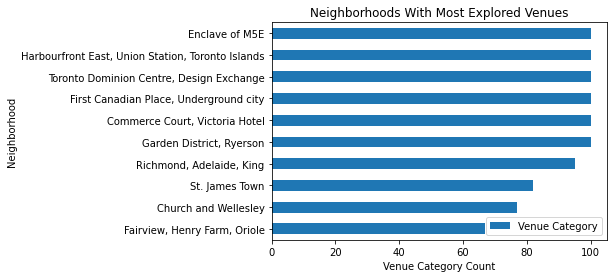

In [17]:
Boroughs_With_Most_Explored_Venues.plot(kind='barh')

plt.xlabel('Venue Category Count') # add x-label to the plot
plt.ylabel('Neighborhood') # add to y-label to the plot
plt.title('Neighborhoods With Most Explored Venues') # add title to the plot

plt.show()


In [18]:
#creating a map shwing the venue catogories in the most explored boroughs
Boroughs_With_Most_Explored_Venues.reset_index(inplace = True)
df_most_explored_boroughs = Toronto.loc[Toronto['Neighborhood'].isin(Boroughs_With_Most_Explored_Venues['Neighborhood'])]
df_most_explored_boroughs.reset_index(inplace = True)
df_most_explored_boroughs

,index,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,111,"Garden District, Ryerson",43.657162,-79.378937,UNIQLO ユニクロ,43.655910,-79.380641,Clothing Store
1,112,"Garden District, Ryerson",43.657162,-79.378937,Burrito Boyz,43.656265,-79.378343,Burrito Place
2,113,"Garden District, Ryerson",43.657162,-79.378937,Blaze Pizza,43.656518,-79.380015,Pizza Place
3,114,"Garden District, Ryerson",43.657162,-79.378937,Silver Snail Comics,43.657031,-79.381403,Comic Shop
4,115,"Garden District, Ryerson",43.657162,-79.378937,Page One Cafe,43.657772,-79.376073,Café
...,...,...,...,...,...,...,...,...
916,2091,Church and Wellesley,43.665860,-79.383160,Alexander Wood Statue,43.663702,-79.380301,Sculpture Garden
917,2092,Church and Wellesley,43.665860,-79.383160,Town Inn Suites,43.669056,-79.382573,Hotel
918,2093,Church and Wellesley,43.665860,-79.383160,Croissant Tree,43.669575,-79.382331,Coffee Shop
919,2094,Church and Wellesley,43.665860,-79.383160,McDonald's,43.668854,-79.385962,Fast Food Restaurant


In [19]:
map_toronto = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, venue_category, neighborhood in zip(df_most_explored_boroughs['Venue Latitude'], df_most_explored_boroughs['Venue Longitude'], df_most_explored_boroughs['Venue Category'], df_most_explored_boroughs['Neighborhood']):
    label = '{}, {}'.format(venue_category, neighborhood)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)  
    
map_toronto

In [20]:
#The highest explored venue categories 
df_most_explored_boroughs.groupby('Venue Category').count().sort_values("Neighborhood").tail(10)[['Neighborhood']]

,Neighborhood
Venue Category,
American Restaurant,14
Gym,17
Seafood Restaurant,19
Italian Restaurant,21
Clothing Store,26
Japanese Restaurant,27
Restaurant,33
Hotel,36
Café,40


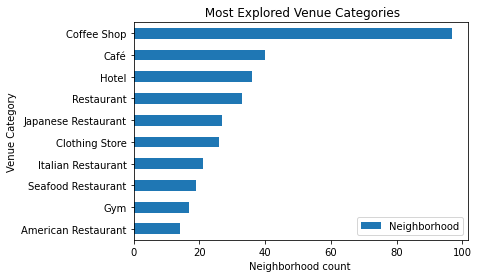

In [21]:
df_most_explored_boroughs.groupby('Venue Category').count().sort_values("Neighborhood").tail(10)[['Neighborhood']].plot(kind='barh')

plt.xlabel('Neighborhood count ') # add x-label to the plot
plt.ylabel('Venue Category') # add to y-label to the plot
plt.title(' Most Explored Venue Categories') # add title to the plot

plt.show()

## Exploring all the Neighbourhoods


In [22]:
# one hot encoding
Toronto_onehot = pd.get_dummies(Toronto[['Venue Category']], prefix="", prefix_sep="")
#Rename the neighborhood venue category
Toronto_onehot.rename(columns = {'Neighborhood': 'Neighborhood_venue'}, inplace = True)
# add neighborhood column back to dataframe in the first column
Toronto_onehot.insert(0, 'Neighborhood', Toronto['Neighborhood'] )

Toronto_onehot.head()

,Neighborhood,Accessories Store,Adult Boutique,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,...,Truck Stop,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio
0,Parkwoods,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Parkwoods,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Parkwoods,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Victoria Village,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Victoria Village,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [23]:
Toronto_onehot.shape

(2130, 277)

In [24]:
Toronto_grouped = Toronto_onehot.groupby('Neighborhood').mean().reset_index()
Toronto_grouped

,Neighborhood,Accessories Store,Adult Boutique,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,...,Truck Stop,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio
0,Agincourt,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,"Alderwood, Long Branch",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,"Bathurst Manor, Wilson Heights, Downsview North",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Bayview Village,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,"Bedford Park, Lawrence Manor East",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96,"Willowdale, Newtonbrook",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
97,Woburn,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
98,Woodbine Heights,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
99,York Mills West,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [25]:
Toronto_grouped.shape

(101, 277)

In [26]:
#define a function that returns the top n venues
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [27]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = Toronto_grouped['Neighborhood']

for ind in np.arange(Toronto_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(Toronto_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Agincourt,Lounge,Breakfast Spot,Chinese Restaurant,Latin American Restaurant,Yoga Studio,Electronics Store,Donut Shop,Drugstore,Dumpling Restaurant,Eastern European Restaurant
1,"Alderwood, Long Branch",Pizza Place,Sandwich Place,Playground,Coffee Shop,Pub,Pharmacy,Gym,Gourmet Shop,Distribution Center,Department Store
2,"Bathurst Manor, Wilson Heights, Downsview North",Bank,Coffee Shop,Grocery Store,Supermarket,Sushi Restaurant,Restaurant,Intersection,Mobile Phone Shop,Fried Chicken Joint,Ice Cream Shop
3,Bayview Village,Café,Japanese Restaurant,Chinese Restaurant,Bank,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Dumpling Restaurant,Yoga Studio
4,"Bedford Park, Lawrence Manor East",Sandwich Place,Italian Restaurant,Restaurant,Coffee Shop,Pizza Place,Pharmacy,Butcher,Café,Pub,Pet Store


## CLUSTER NEIGHBORHOOD

In [28]:
# import k-means from clustering stage
from sklearn.cluster import KMeans

# set number of clusters
kclusters = 5

Toronto_grouped_clustering = Toronto_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(Toronto_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([3, 3, 3, 3, 3, 3, 3, 3, 3, 2])

In [29]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

Toronto_merged = df_explore

# merge manhattan_grouped with manhattan_data to add latitude/longitude for each neighborhood
Toronto_merged = Toronto_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

Toronto_merged.head()

,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,North York,Parkwoods,43.753259,-79.329656,2.0,Fast Food Restaurant,Park,Food & Drink Shop,Eastern European Restaurant,Distribution Center,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Dumpling Restaurant
1,North York,Victoria Village,43.725882,-79.315572,3.0,Nail Salon,Grocery Store,Hockey Arena,Portuguese Restaurant,Coffee Shop,Dumpling Restaurant,Discount Store,Distribution Center,Dog Run,Doner Restaurant
2,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636,3.0,Coffee Shop,Bakery,Park,Breakfast Spot,Café,Pub,Theater,Spa,Shoe Store,Restaurant
3,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763,3.0,Clothing Store,Accessories Store,Furniture / Home Store,Boutique,Vietnamese Restaurant,Coffee Shop,Miscellaneous Shop,Eastern European Restaurant,Doner Restaurant,Donut Shop
4,Queen's Park,Ontario Provincial Government,43.662301,-79.389494,3.0,Coffee Shop,Sushi Restaurant,Bar,Beer Bar,Spa,Smoothie Shop,Sandwich Place,Burrito Place,Salad Place,Café


In [30]:
# create map showing the different clusters
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)


#Toronto_merged = Toronto_merged.astype({'Cluster Labels': int})

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, hood ,cluster in zip(Toronto_merged['Latitude'], Toronto_merged['Longitude'], Toronto_merged['Neighborhood'], Toronto_merged['Cluster Labels']):
    #To encapsulate the outliers
    if cluster == 0:
        cluster =0
    elif cluster == 1:
        cluster = 1
    elif cluster == 2:
        cluster = 2
    elif cluster == 3:
        cluster = 3
    elif cluster == 4:
        cluster = 4
    else:
        cluster = 5
    
        
    label = folium.Popup(str(hood) +','+ ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        #fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

## Examine clusters

In [31]:
Toronto_merged.loc[Toronto_merged['Cluster Labels'] == 0, Toronto_merged.columns[[1] + list(range(5, Toronto_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
45,"York Mills, Silver Hills",Cafeteria,Yoga Studio,Eastern European Restaurant,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Dumpling Restaurant,Electronics Store,Filipino Restaurant


In [32]:
Toronto_merged.loc[Toronto_merged['Cluster Labels'] == 1, Toronto_merged.columns[[1] + list(range(5, Toronto_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
53,Downsview Central,Home Service,Food Truck,Baseball Field,Yoga Studio,Electronics Store,Doner Restaurant,Donut Shop,Drugstore,Dumpling Restaurant,Eastern European Restaurant
57,"Humberlea, Emery",Baseball Field,Furniture / Home Store,Yoga Studio,Doner Restaurant,Donut Shop,Drugstore,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Distribution Center
101,"Old Mill South, King's Mill Park, Sunnylea, Hu...",Baseball Field,Yoga Studio,Doner Restaurant,Donut Shop,Drugstore,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Escape Room,Distribution Center


In [33]:
Toronto_merged.loc[Toronto_merged['Cluster Labels'] == 2, Toronto_merged.columns[[1] + list(range(5, Toronto_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Parkwoods,Fast Food Restaurant,Park,Food & Drink Shop,Eastern European Restaurant,Distribution Center,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Dumpling Restaurant
21,Caledonia-Fairbanks,Park,Women's Store,Pool,Eastern European Restaurant,Distribution Center,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Dumpling Restaurant
35,The Danforth East,Park,Convenience Store,Yoga Studio,Eastern European Restaurant,Distribution Center,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Dumpling Restaurant
40,Downsview East,Airport,Park,Yoga Studio,Electronics Store,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Dumpling Restaurant,Eastern European Restaurant
52,"Willowdale, Newtonbrook",Park,Yoga Studio,Eastern European Restaurant,Distribution Center,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Dumpling Restaurant,Electronics Store
61,Lawrence Park,Park,Bus Line,Swim School,Yoga Studio,Dumpling Restaurant,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Eastern European Restaurant
64,Weston,Park,Convenience Store,Yoga Studio,Eastern European Restaurant,Distribution Center,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Dumpling Restaurant
66,York Mills West,Electronics Store,Park,Convenience Store,Eastern European Restaurant,Distribution Center,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Dumpling Restaurant
83,"Moore Park, Summerhill East",Park,Tennis Court,Yoga Studio,Dumpling Restaurant,Discount Store,Distribution Center,Dog Run,Doner Restaurant,Donut Shop,Drugstore
85,"Milliken, Agincourt North, Steeles East, L'Amo...",Intersection,Playground,Park,Dumpling Restaurant,Discount Store,Distribution Center,Dog Run,Doner Restaurant,Donut Shop,Drugstore


In [34]:
Toronto_merged.loc[Toronto_merged['Cluster Labels'] == 3, Toronto_merged.columns[[1] + list(range(5, Toronto_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,Victoria Village,Nail Salon,Grocery Store,Hockey Arena,Portuguese Restaurant,Coffee Shop,Dumpling Restaurant,Discount Store,Distribution Center,Dog Run,Doner Restaurant
2,"Regent Park, Harbourfront",Coffee Shop,Bakery,Park,Breakfast Spot,Café,Pub,Theater,Spa,Shoe Store,Restaurant
3,"Lawrence Manor, Lawrence Heights",Clothing Store,Accessories Store,Furniture / Home Store,Boutique,Vietnamese Restaurant,Coffee Shop,Miscellaneous Shop,Eastern European Restaurant,Doner Restaurant,Donut Shop
4,Ontario Provincial Government,Coffee Shop,Sushi Restaurant,Bar,Beer Bar,Spa,Smoothie Shop,Sandwich Place,Burrito Place,Salad Place,Café
6,"Malvern, Rouge",Fast Food Restaurant,Print Shop,Eastern European Restaurant,Distribution Center,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Dumpling Restaurant,Electronics Store
...,...,...,...,...,...,...,...,...,...,...,...
97,"First Canadian Place, Underground city",Coffee Shop,Café,Hotel,Restaurant,Japanese Restaurant,Gym,Seafood Restaurant,American Restaurant,Deli / Bodega,Steakhouse
98,"The Kingsway, Montgomery Road, Old Mill North",River,Pool,Yoga Studio,Dumpling Restaurant,Distribution Center,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Eastern European Restaurant
99,Church and Wellesley,Coffee Shop,Sushi Restaurant,Japanese Restaurant,Restaurant,Gay Bar,Men's Store,Fast Food Restaurant,Hotel,Mediterranean Restaurant,Yoga Studio
100,Enclave of M4L,Yoga Studio,Pizza Place,Smoke Shop,Skate Park,Brewery,Burrito Place,Restaurant,Recording Studio,Park,Auto Workshop


In [35]:
Toronto_merged.loc[Toronto_merged['Cluster Labels'] == 4, Toronto_merged.columns[[1] + list(range(5, Toronto_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
12,"Rouge Hill, Port Union, Highland Creek",Bar,Yoga Studio,Electronics Store,Doner Restaurant,Donut Shop,Drugstore,Dumpling Restaurant,Eastern European Restaurant,Escape Room,Distribution Center


In [36]:
Toronto_merged.loc[Toronto_merged['Cluster Labels'].isnull(), Toronto_merged.columns[[1] + list(range(5, Toronto_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
5,Islington Avenue,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
95,Upper Rouge,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Exploring the clusters in respect to the top 10 most explored neighbourhood

In [37]:
Toronto_merged_most_explored_hood = Toronto_merged.loc[Toronto_merged['Neighborhood'].isin(df_most_explored_boroughs['Neighborhood'])]
Toronto_merged_most_explored_hood.reset_index(inplace = True)
Toronto_merged_most_explored_hood = Toronto_merged_most_explored_hood.drop(columns=['index'])
Toronto_merged_most_explored_hood

,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Downtown Toronto,"Garden District, Ryerson",43.657162,-79.378937,3.0,Coffee Shop,Clothing Store,Hotel,Italian Restaurant,Bubble Tea Shop,Middle Eastern Restaurant,Cosmetics Shop,Japanese Restaurant,Café,Pizza Place
1,Downtown Toronto,St. James Town,43.651494,-79.375418,3.0,Coffee Shop,Café,Gastropub,Cocktail Bar,Park,Farmers Market,Seafood Restaurant,Restaurant,Cheese Shop,Clothing Store
2,Downtown Toronto,"Richmond, Adelaide, King",43.650571,-79.384568,3.0,Coffee Shop,Café,Thai Restaurant,Restaurant,Clothing Store,Hotel,Gym,Deli / Bodega,Burrito Place,Salad Place
3,North York,"Fairview, Henry Farm, Oriole",43.778517,-79.346556,3.0,Clothing Store,Coffee Shop,Fast Food Restaurant,Japanese Restaurant,Restaurant,Bank,Juice Bar,Toy / Game Store,Women's Store,Shoe Store
4,Downtown Toronto,"Harbourfront East, Union Station, Toronto Islands",43.640816,-79.381752,3.0,Coffee Shop,Aquarium,Café,Hotel,Sporting Goods Shop,Restaurant,Brewery,Italian Restaurant,Scenic Lookout,Fried Chicken Joint
5,Downtown Toronto,"Toronto Dominion Centre, Design Exchange",43.647177,-79.381576,3.0,Coffee Shop,Hotel,Café,Japanese Restaurant,Seafood Restaurant,Salad Place,Restaurant,Italian Restaurant,Gastropub,Sporting Goods Shop
6,Downtown Toronto,"Commerce Court, Victoria Hotel",43.648198,-79.379817,3.0,Coffee Shop,Restaurant,Hotel,Café,Italian Restaurant,Gym,Seafood Restaurant,Japanese Restaurant,Cocktail Bar,Deli / Bodega
7,Downtown Toronto Stn A,Enclave of M5E,43.646435,-79.374846,3.0,Coffee Shop,Cocktail Bar,Seafood Restaurant,Japanese Restaurant,Restaurant,Café,Beer Bar,Hotel,Bakery,Italian Restaurant
8,Downtown Toronto,"First Canadian Place, Underground city",43.648429,-79.382280,3.0,Coffee Shop,Café,Hotel,Restaurant,Japanese Restaurant,Gym,Seafood Restaurant,American Restaurant,Deli / Bodega,Steakhouse
9,Downtown Toronto,Church and Wellesley,43.665860,-79.383160,3.0,Coffee Shop,Sushi Restaurant,Japanese Restaurant,Restaurant,Gay Bar,Men's Store,Fast Food Restaurant,Hotel,Mediterranean Restaurant,Yoga Studio


In [38]:
Toronto_merged_most_explored_hood['Cluster Labels'].unique()

array([3.])

### We can see that all the most explored neighborhoods belong to cluster 3

## Results and Discussions

Let us look at our results in two aspects.

Our first exploration was to determine the most explored neighborhoods and the most explored venues in those neighbourhoods. From this, if our investor is looking to go into business in busy neighbourhoods, then we will recommend areas like:  Church and Wellesley, First Canadian Place, Underground city, Enclave of M5E, Commerce Court, Victoria Hotel, Toronto Dominion Centre, Design Exchange and businesses like: coffee shop, cafe, hotel or restaurant. 

Secondly, using the analysis of our clusters, the business prospect for our investor will depend on the cluster the neighborhood belongs to. For cluster 0, the most profitable business choice will be Cafeteria, Yoga Studio or Eastern European Restaurant. For cluster 1, the most profitable business choice will be baseball field, home service and yoga studio. For cluster 2, the most profitable business choice will be Park or Convenience Store. For cluster 3, the most profitable business choice will be Coffee Shop, Cafe or Pizza Place. For cluster 4, the most profitable business choice will be Cafeteria, Bar	Yoga Studio. 

## Conclusion

In this study, we analyzed the relationship between neighborhoods in Toronto and Exploration of Venues in those neighborhoods. We identified the most explored neighborhoods and the most explored venues. We models Clustering models to determine the most profitable business prospects based on the neighborhood. This can be very useful in helping a business investor hoping to invest in or start a business in Ontario. For example, it could help identify what neighborhood to invest in and what type of business to invest in. With the help of the model, one cn also recognize unexplored neighborhoods.